In [ ]:
#| default_exp dtcam

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
from IPython.display import Image
from llmcam.gpt4v import *
from llmcam.yolo import *
from llmcam.fn_to_fc import *
from llmcam.downloader import *
import json

In [ ]:
#| export
import requests
from pathlib import Path
from PIL import Image
from io import BytesIO
from datetime import datetime
import os

In [ ]:
#| export
stations_url = "https://tie.digitraffic.fi/api/weathercam/v1/stations"

## build an addressbook of camera installed address, and image capture url
```
[
    {
        "address": <camera installed location>,
        "url": <capture image url>,
    },
    {
        "address": <camera installed location>,
        "url": <capture image url>,
    },
    ....
]
```

In [ ]:
def build_address_book(stations_url:str):
    table = []
    stations = requests.get(stations_url).json()['features']
    for station in stations:
        station = requests.get(stations_url+'/'+station['id']).json().get('properties')
        if not station:
            continue
        for preset in station['presets']:
            try:
                addr = ",".join([preset['presentationName'], station['names'].get('fi'), station['municipality'], station['province']])
            except:
                continue
            info = {
                #"id": preset['id'],
                "address": addr,
                "url": preset['imageUrl'],
            }
            table.append(info)
    return table

In [ ]:
def address_book(stations_url:str=stations_url, force_update=False):
    """get an address book [{"address":<camera installed address>, "url":<image capture url>}]"""
    if not force_update and os.path.exists("preset_image_url.json"):
        with open("preset_image_url.json", "r") as f:
            return json.load(f)
    raise
    data = build_address_book(stations_url)
    with open("preset_image_url.json", "w") as f:
        json.dump(data, f, indent=4) 
    return data

In [ ]:
#| export
def camera_address_book(
    stations_url:str=stations_url, # Weather Camera URL
    update:bool=False,             # Update addressbook forcely
)->str:                            # List of `"camera location"`:`"image url"`
    """get weather camera location addressbook of `camera location`:`image url`. You can get an capture of camera from this url"""   
    data = address_book(stations_url, update)
    return json.dumps(data)

In [ ]:
show_doc(camera_address_book)

---

[source](https://github.com/ninjalabo/llmcam/blob/main/llmcam/vision/dtcam.py#L20){target="_blank" style="float:right; font-size:smaller"}

### camera_address_book

>      camera_address_book (stations_url:str='https://tie.digitraffic.fi/api/wea
>                           thercam/v1/stations', update:bool=False)

*get weather camera location addressbook of `camera location`:`image url`. You can get an capture of camera from this url*

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| stations_url | str | https://tie.digitraffic.fi/api/weathercam/v1/stations | Weather Camera URL |
| update | bool | False | Update addressbook forcely |
| **Returns** | **str** |  | **List of `"camera location"`:`"image url"`** |

In [ ]:
#| eval: false
tools = [tool_schema(f) for f in [camera_address_book, download_file, ask_gpt4v_about_image_file]]
msgs = form_msgs([
    ("system", "You are a helpful system administrator. Use the supplied tools to assist the user."),
    ("user", "Pick up the camera location closer to Espoo Kehä I Itään from camera address book"),
])
complete(msgs, tools=tools)
msgs.append(form_msg("user", "download captured images"))
complete(msgs, tools=tools)
msgs.append(form_msg("user", "How many cars are seen?"))
complete(msgs, tools=tools)
print_msgs(msgs)

>> System:
You are a helpful system administrator. Use the supplied tools to assist the user.
>> User:
Pick up the camera location closer to Espoo Kehä I Itään from camera address book
>> Assistant:
I attempted to retrieve the camera location information from the camera address book at the provided
URL, but it appears that the information is currently unavailable. Would you like me to try another
approach, or is there anything else I can assist you with?
>> User:
download captured images
>> Assistant:
To download captured images from weather cameras, I'll first need the list of camera URLs or the
specific camera location URL to proceed with the download. If you have any URLs or specific camera
locations in mind, please provide them.
>> User:
How many cars are seen?
>> Assistant:
To determine how many cars are seen in an image, I'll first need to download the image from a
specified URL. Once you give me the image URL or the specific camera location URL, I'll download the
image and then 

## Simple capture function

In [ ]:
#| export
def stations(key:str)->list[dict]:
    "Get all weather station including `key` word"
    res = requests.get(stations_url)
    assert res.status_code == 200
    stations = res.json()['features']
    return [st for st in stations if key.lower() in st['properties']['name'].lower()]

In [ ]:
Porvoos = stations("Porvoo")
assert "porvoo" in Porvoos[0]['properties']['name'].lower()

In [ ]:
#| export
def presets(station:dict)->list[dict]:
    "Get all presets at a given weather station"
    res = requests.get(stations_url + "/" + station['id'])
    assert res.status_code == 200
    presets = res.json()['properties']['presets']
    return presets

In [ ]:
preset = presets(Porvoos[0])[0]
imageUrl = preset['imageUrl']
print(imageUrl)
assert "jpg" in imageUrl

https://weathercam.digitraffic.fi/C0150200.jpg


In [ ]:
#| export
def capture(preset:dict)->Path:
    "Capture image at a given preset location in a Weather station, and return an image path"
    req = requests.get(preset['imageUrl'], headers={'Digitraffic-User': 'NinjaLABO/LLMCAM 1.0'})
    assert req.status_code == 200
    img = Image.open(BytesIO(req.content))
    #img.show()
    dt = datetime.strptime(req.headers["last-modified"], '%a, %d %b %Y %H:%M:%S %Z')
    dtstr = dt.strftime("%Y.%m.%d_%H:%M:%S")
    dir = os.getenv("LLMCAM_DATA", "../data")
    path = f"{dir}/cap_{dtstr}_{preset['presentationName']}_{preset['id']}.jpg"
    img.save(path, format="JPEG")
    return req.headers, path

In [ ]:
preset

{'id': 'C0150200',
 'presentationName': 'Porvoo',
 'inCollection': True,
 'resolution': '704x576',
 'directionCode': '0',
 'imageUrl': 'https://weathercam.digitraffic.fi/C0150200.jpg',
 'direction': 'UNKNOWN'}

In [ ]:
hdr, path = capture(preset)
hdr

{'Content-Type': 'image/jpeg', 'Content-Length': '66299', 'Connection': 'keep-alive', 'x-amz-id-2': 'A4ptiebWMRFs2yp6ultZs4qly/k8FcaGIVztPBgbZecVzax50DnXbhJ73BrnM39tChgbE8tBq9t9OCAjQCG+gw==', 'x-amz-request-id': '9ENFG21QNTEAAGVX', 'last-modified': 'Mon, 09 Dec 2024 20:53:06 GMT', 'x-amz-expiration': 'expiry-date="Wed, 11 Dec 2024 00:00:00 GMT", rule-id="Delete versions and current images after 24h"', 'x-amz-server-side-encryption': 'AES256', 'X-Amz-Meta-Last-Modified': 'Mon, 09 Dec 2024 20:53:06 GMT', 'x-amz-version-id': 'mdewfZ4KPLTCMgWqIIGL4Ixd0FQjNlBk', 'Accept-Ranges': 'bytes', 'Server': 'AmazonS3', 'Date': 'Mon, 09 Dec 2024 20:59:04 GMT', 'ETag': '"3776b76a1cb7e745441d504d57f720ed"', 'Vary': 'Accept-Encoding', 'X-Cache': 'Hit from cloudfront', 'Via': '1.1 28854270ecee3f8e2272bf40b3de08fa.cloudfront.net (CloudFront)', 'X-Amz-Cf-Pop': 'HEL51-P1', 'Alt-Svc': 'h3=":443"; ma=86400', 'X-Amz-Cf-Id': 'QVgwuF0YowAm-1e02YcMRgFW6FdbyK2m8NNZZ5gbESyevGW87GC9Eg==', 'Age': '76'}

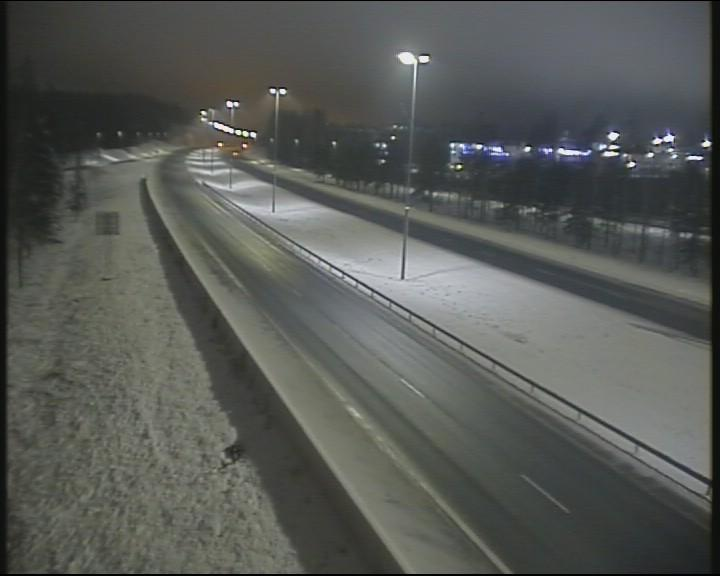

In [ ]:
display(Image.open(path))

In [ ]:
#| export
def cap(
    key:str = "Porvoo", # location keyword
)->str:
    "Capture an image at specified location, save it, and return its path"
    _, path = capture(presets(stations(key)[0])[0])
    return str(path)

In [ ]:
show_doc(cap)

---

[source](https://github.com/ninjalabo/llmcam/blob/main/llmcam/vision/dtcam.py#L59){target="_blank" style="float:right; font-size:smaller"}

### cap

>      cap (key:str='Porvoo')

*Capture an image at specified location, save it, and return its path*

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| key | str | Porvoo | location keyword |
| **Returns** | **str** |  |  |

In [ ]:
#| eval: false
path = cap("porvoo")
print(path)
ask_gpt4v(path)

/home/nghivo/tinyMLaaS/llmcam/data/cap_2024.12.09_20:53:06_Porvoo_C0150200.jpg


{'dimensions': [720, 576],
 'building': 0,
 'car': 0,
 'truck': 0,
 'boat': 0,
 'available_parking_space': 0,
 'street_lights': 6,
 'person': 0,
 'time_of_day': 'night',
 'artificial_lighting': 1,
 'visibility_clear': True,
 'sky_visible': True,
 'sky_light_conditions': 'cloudy',
 'waterbodies_visible': False}

In [ ]:
#| eval: false
detect_objects(cap('porvoo'))


image 1/1 /home/doyu/00llmcam/nbs/../data/cap_2024.12.02_15:53:57_Porvoo_C0150200.jpg: 512x640 1 car, 208.4ms
Speed: 7.1ms preprocess, 208.4ms inference, 6.1ms postprocess per image at shape (1, 3, 512, 640)


'{"car": 1}'

In [ ]:
#| eval: false
def __ask_gpt4v(
    path: str # file path to analyze
)->str:
    "ask gpt4v to analyze an image given"
    return json.dumps(ask_gpt4v(path))

In [ ]:
#| eval: false
show_doc(__ask_gpt4v)

---

### __ask_gpt4v

>      __ask_gpt4v (path:str)

*ask gpt4v to analyze an image given*

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| path | str | file path to analyze |
| **Returns** | **str** |  |

In [ ]:
#| eval: false
tools = [tool_schema(f) for f in [cap, detect_objects, __ask_gpt4v] ]
tools

[{'type': 'function',
  'function': {'name': 'cap',
   'description': 'Capture an image at specified location, save it, and return its path',
   'parameters': {'type': 'object',
    'properties': {'key': {'type': 'string',
      'description': 'location keyword'}},
    'required': []},
   'metadata': {'module': '__main__', 'service': '__main__'}}},
 {'type': 'function',
  'function': {'name': 'detect_objects',
   'description': 'Detect object in the input image.',
   'parameters': {'type': 'object',
    'properties': {'image_path': {'type': 'string',
      'description': 'Path/URL of image'},
     'conf': {'type': 'number', 'description': 'Confidence threshold'}},
    'required': ['image_path']},
   'metadata': {'module': 'llmcam.yolo', 'service': 'llmcam.yolo'}}},
 {'type': 'function',
  'function': {'name': '__ask_gpt4v',
   'description': 'ask gpt4v to analyze an image given',
   'parameters': {'type': 'object',
    'properties': {'path': {'type': 'string',
      'description': 'fil

In [ ]:
def callback(name, tools=[], **kwargs): return globals().get(name)(**kwargs)

In [ ]:
#| eval: false
msgs = form_msgs([
    ("system", "You are a helpful system administrator. Use the supplied tools to assist the user."),
    ("user", "Capture an image in Porvoo and tell me the path"),
])
complete(msgs, tools=tools)

('assistant',
 'The image has been captured in Porvoo. You can find it at the following path: `../data/cap_2024.12.02_15:53:57_Porvoo_C0150200.jpg`.')

In [ ]:
#| eval: false
msgs.append(form_msg("user", f"analyze this captured image"))
complete(msgs, tools=tools)

('assistant',
 'The analysis of the captured image from Porvoo reveals the following details:\n\n- **Dimensions**: 720 x 576 pixels\n- **Objects Detected**:\n  - 1 Truck\n  - 4 Cars\n  - 5 Street lights\n- **Time of Day**: Night\n- **Lighting Conditions**: Prominent artificial lighting\n- **Visibility**: Clear\n- **Sky Visibility**: Not visible\n- **Water Bodies**: Not visible\n\nThis suggests a clear night scene with vehicular presence and strong street lighting.')

In [ ]:
#| eval: false
msgs.append(form_msg("user", "Can you detect objects in the file?"))
complete(msgs, tools=tools)


image 1/1 /home/doyu/00llmcam/nbs/../data/cap_2024.12.02_15:53:57_Porvoo_C0150200.jpg: 512x640 1 car, 162.3ms
Speed: 2.2ms preprocess, 162.3ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


('assistant',
 'The object detection in the captured image from Porvoo identified the following:\n\n- **1 Car**\n\nIt seems there was one car detected in the image.')

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()